In [ ]:
%pip install pyspark
%pip install matplotlib seaborn
%pip install wordcloud
%pip install --upgrade seaborn
%pip install numpy pandas seaborn matplotlib
%pip install seaborn squarify plotly kaleido



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, when, desc, year, month, datediff
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import numpy as np

In [ ]:
# Initialize a Spark session
spark = SparkSession.builder.appName("CreditCardIssuerMarketShare").getOrCreate()

# Load the dataset
file_path = "/content/cfpb_college-credit-card-agreements-database-2009-2019 (2).csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# df.printSchema()
df.show(5)

+--------------+---------------------------+-----------------------------------+-----------+-----+--------------------+------+--------------------------------------+-----------------------------------------------+------------------+-------------------------------------+
|REPORTING YEAR|INSTITUTION OR ORGANIZATION|TYPE OF INSTITUTION OR ORGANIZATION|       CITY|STATE|  CREDIT CARD ISSUER|STATUS|IN EFFECT AS OF BEGINNING OF NEXT YEAR|TOTAL OPEN ACCOUNTS AS OF END OF REPORTING YEAR|PAYMENTS BY ISSUER|NEW ACCOUNTS OPENED IN REPORTING YEAR|
+--------------+---------------------------+-----------------------------------+-----------+-----+--------------------+------+--------------------------------------+-----------------------------------------------+------------------+-------------------------------------+
|          2009|       Educational Commu...|                              Other|Lake Forest|   IL|FIA Card Services...|  NULL|                                  NULL|                      

In [ ]:
# Rename the columns
df = df.select([
    col("REPORTING YEAR").alias("year"),
    col("INSTITUTION OR ORGANIZATION").alias("institution"),
    col("TYPE OF INSTITUTION OR ORGANIZATION").alias("institution_type"),
    col("CITY").alias("city"),
    col("STATE").alias("state"),
    col("CREDIT CARD ISSUER").alias("issuer"),
    col("STATUS").alias("status"),
    col("IN EFFECT AS OF BEGINNING OF NEXT YEAR").alias("in_effect_next_year"),
    col("TOTAL OPEN ACCOUNTS AS OF END OF REPORTING YEAR").alias("total_accounts"),
    col("PAYMENTS BY ISSUER").alias("issuer_payments"),
    col("NEW ACCOUNTS OPENED IN REPORTING YEAR").alias("new_accounts")
])

# Show the new schema
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- institution: string (nullable = true)
 |-- institution_type: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- issuer: string (nullable = true)
 |-- status: string (nullable = true)
 |-- in_effect_next_year: string (nullable = true)
 |-- total_accounts: integer (nullable = true)
 |-- issuer_payments: string (nullable = true)
 |-- new_accounts: string (nullable = true)



# 1. Data Preprocessing

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

# Function to save figures
def save_figure(fig, filename):
    # Save as PNG
    fig.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')
    # Save as PDF
    with PdfPages(f'{filename}.pdf') as pdf:
        pdf.savefig(fig, bbox_inches='tight')

In [ ]:
df = df.withColumn("total_accounts", col("total_accounts").cast(IntegerType()))
df = df.withColumn("issuer_payments", col("issuer_payments").cast("double"))
df = df.withColumn("new_accounts", col("new_accounts").cast(IntegerType()))

# Handle missing values
df = df.na.fill({"total_accounts": 0, "issuer_payments": 0, "new_accounts": 0})
df = df.na.fill({"status": "Unknown", "in_effect_next_year": "Unknown"})

# df.printSchema()
df.show(5)

+----+--------------------+------------------+-----------+-----+--------------------+-------+-------------------+--------------+---------------+------------+
|year|         institution|  institution_type|       city|state|              issuer| status|in_effect_next_year|total_accounts|issuer_payments|new_accounts|
+----+--------------------+------------------+-----------+-----+--------------------+-------+-------------------+--------------+---------------+------------+
|2009|Educational Commu...|             Other|Lake Forest|   IL|FIA Card Services...|Unknown|            Unknown|         10765|            0.0|           0|
|2009|The Alumni Associ...|Alumni Association|   Lincoln |   NE|          Chase Bank|Unknown|            Unknown|          8368|            0.0|           0|
|2009|Brazos Higher Edu...|             Other|       Waco|   TX|FIA Card Services...|Unknown|            Unknown|          1086|            0.0|           0|
|2009|Regents of the Un...|        University|Minnea

# 2. Exploratory Data Analysis

In [ ]:
from pyspark.sql.functions import desc, col, count

# distribution of institution types
print("\nDistribution of institution types (top 5 most common):")
institution_types = df.groupBy("institution_type").count().orderBy(desc("count"))
institution_types.show(5, truncate=False)

# select one unique institution type
unique_institution_type = institution_types.orderBy("count").first()
print(f"\nOne unique institution type: {unique_institution_type['institution_type']} (Count: {unique_institution_type['count']})")

# distribution of status
print("\nDistribution of status:")
status_dist = df.groupBy("status").count().orderBy(desc("count"))
status_dist.show(5, truncate=False)

# select one unique status
unique_status = status_dist.orderBy("count").first()
print(f"\nOne unique status: {unique_status['status']} (Count: {unique_status['count']})")

# distribution of in_effect_next_year
print("\nDistribution of in_effect_next_year:")
in_effect_dist = df.groupBy("in_effect_next_year").count().orderBy(desc("count"))
in_effect_dist.show(5, truncate=False)

# select one unique in_effect_next_year value
unique_in_effect = in_effect_dist.orderBy("count").first()
print(f"\nOne unique in_effect_next_year value: {unique_in_effect['in_effect_next_year']} (Count: {unique_in_effect['count']})")

# summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
summary_stats = df.select("total_accounts", "issuer_payments", "new_accounts").summary()

# select interesting statistics
interesting_stats = summary_stats.filter(col("summary").isin(["count", "mean", "min", "max"]))
interesting_stats.show()

# print one interesting statistic
max_accounts = summary_stats.filter(col("summary") == "max").select("total_accounts").collect()[0][0]
print(f"\nInteresting statistic: Maximum number of total accounts: {max_accounts}")


Distribution of institution types (top 5 most common):
+------------------------------+-----+
|institution_type              |count|
+------------------------------+-----+
|Alumni Association            |2408 |
|University                    |1830 |
|Other                         |810  |
|Foundation                    |404  |
|Alumni Association, University|40   |
+------------------------------+-----+
only showing top 5 rows


One unique institution type: Alumni Association, Other (Count: 2)

Distribution of status:
+----------+-----+
|status    |count|
+----------+-----+
|Same      |2978 |
|Amended   |1145 |
|Unknown   |1051 |
|New       |280  |
|Terminated|22   |
+----------+-----+
only showing top 5 rows


One unique status: Open (Count: 1)

Distribution of in_effect_next_year:
+-------------------+-----+
|in_effect_next_year|count|
+-------------------+-----+
|Yes                |3392 |
|Unknown            |1045 |
|No                 |1020 |
|YES                |58   |
|Yes      

## Univariate Analysis

In [ ]:
from pyspark.sql.functions import col, desc, count, mean, corr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Numerical Variables
numerical_cols = ["total_accounts", "issuer_payments", "new_accounts"]

# Summary statistics
summary_stats = df.select(numerical_cols).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max")
summary_stats_pd = summary_stats.toPandas()

# Print summary statistics
print("\nSummary Statistics for Numerical Variables:")
print(summary_stats_pd.to_string(index=False))


Summary Statistics for Numerical Variables:
summary     total_accounts    issuer_payments      new_accounts
  count               5528               5528              5528
   mean 2155.8106005788713   85393.4196027351 105.7362518089725
 stddev  4994.134753749662 248006.93774542367 392.4323281296201
    min                  0                0.0                 0
    25%                132             345.45                 0
    50%                470             5603.0                 9
    75%               1696           37828.89                59
    max              74832         4292487.99              9544


> Total Accounts: Range from 0 to 74,832, with a median of 470. The maximum is over 150 times the median, indicating significant outliers.

> Issuer Payments: Range from 0 to 4,292,487.99, with a median of $5,603. The maximum is over 760 times the median, suggesting extreme outliers.

> New Accounts: Range from 0 to 9,544, with a median of 9. The maximum is over 1,000 times the median, indicating very extreme outliers.

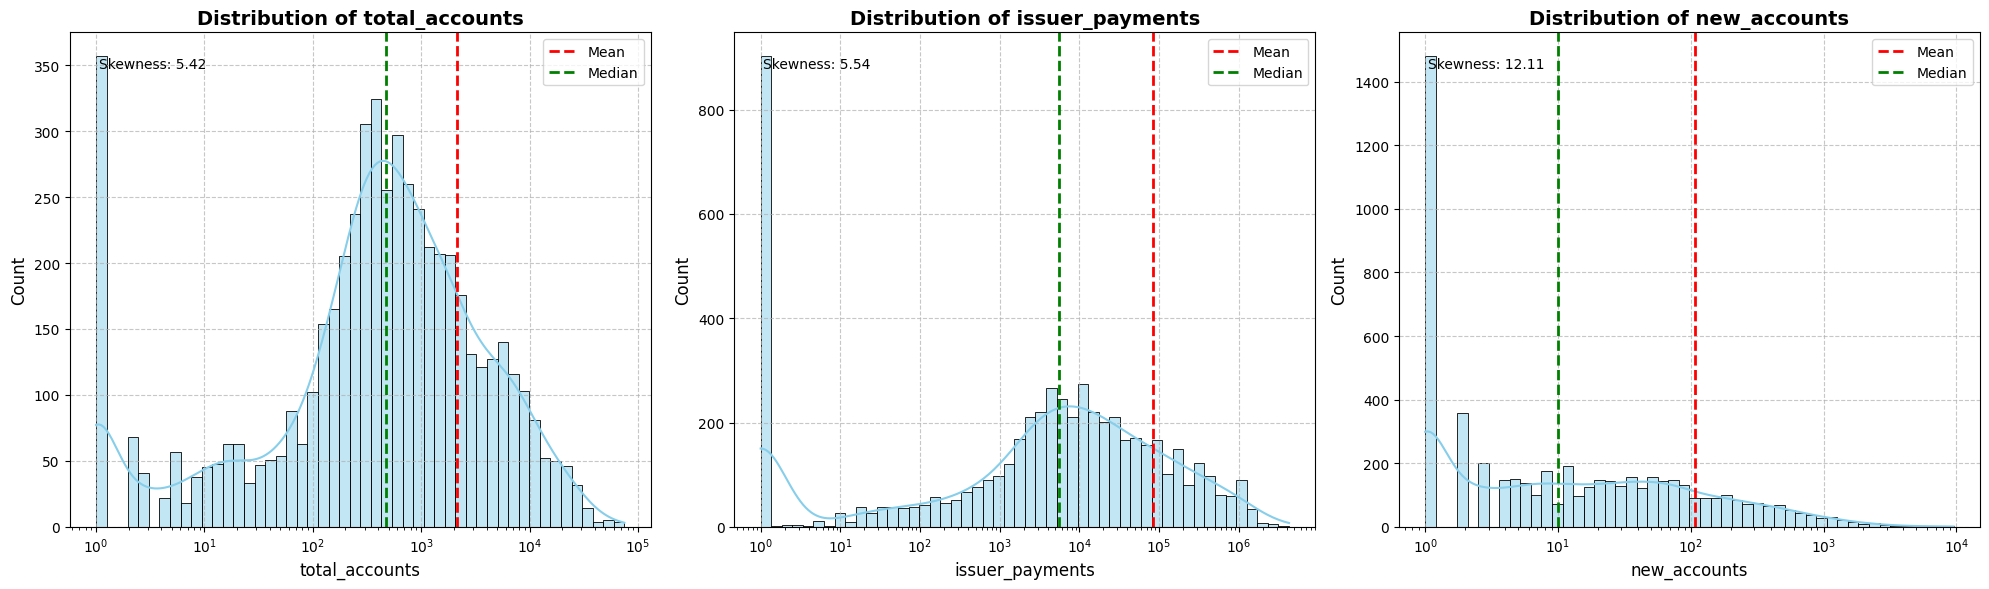

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, col in enumerate(numerical_cols):
    data = df.select(col).toPandas()

    # Use log scale for x-axis
    if data[col].min() <= 0:
        data[col] = data[col] - data[col].min() + 1  # Shift data to be positive for log scale

    sns.histplot(data=data, x=col, kde=True, ax=axes[i], bins=50,
                 color='skyblue', edgecolor='black', log_scale=(True, False))

    # Add mean and median lines
    mean = data[col].mean()
    median = data[col].median()
    axes[i].axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
    axes[i].axvline(median, color='green', linestyle='dashed', linewidth=2, label='Median')

    axes[i].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)

    # Enhance grid for better readability
    axes[i].grid(True, linestyle='--', alpha=0.7)

    # Add legend
    axes[i].legend()

    # Compute and display skewness
    skewness = data[col].skew()
    axes[i].text(0.05, 0.95, f'Skewness: {skewness:.2f}',
                 transform=axes[i].transAxes, fontsize=10,
                 verticalalignment='top')

plt.tight_layout()
# plt.savefig('enhanced_numerical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

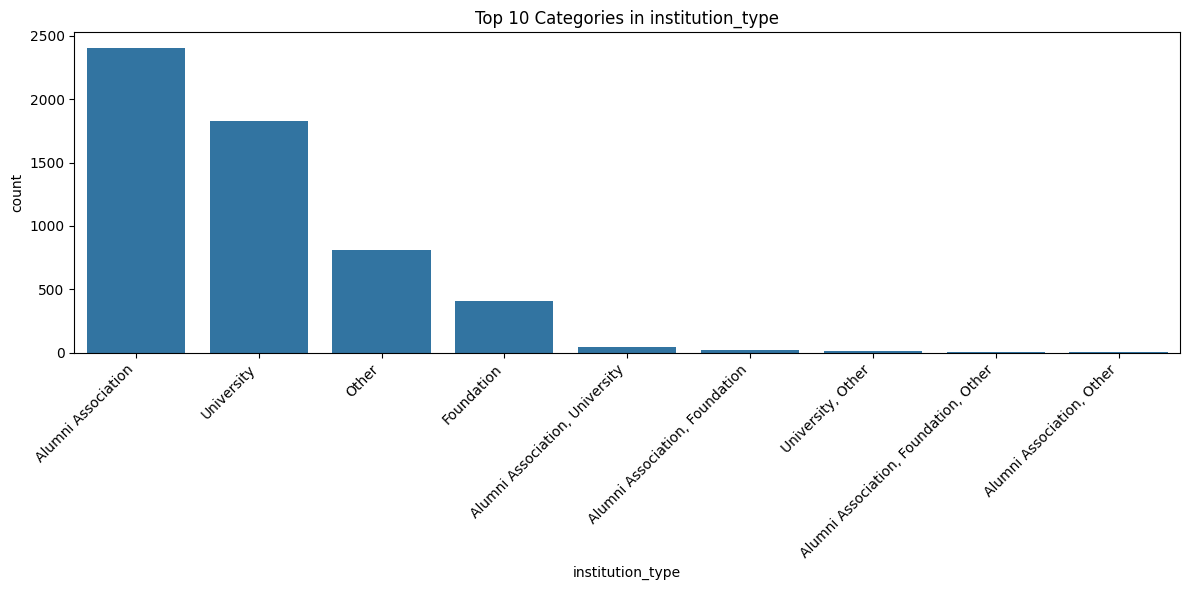

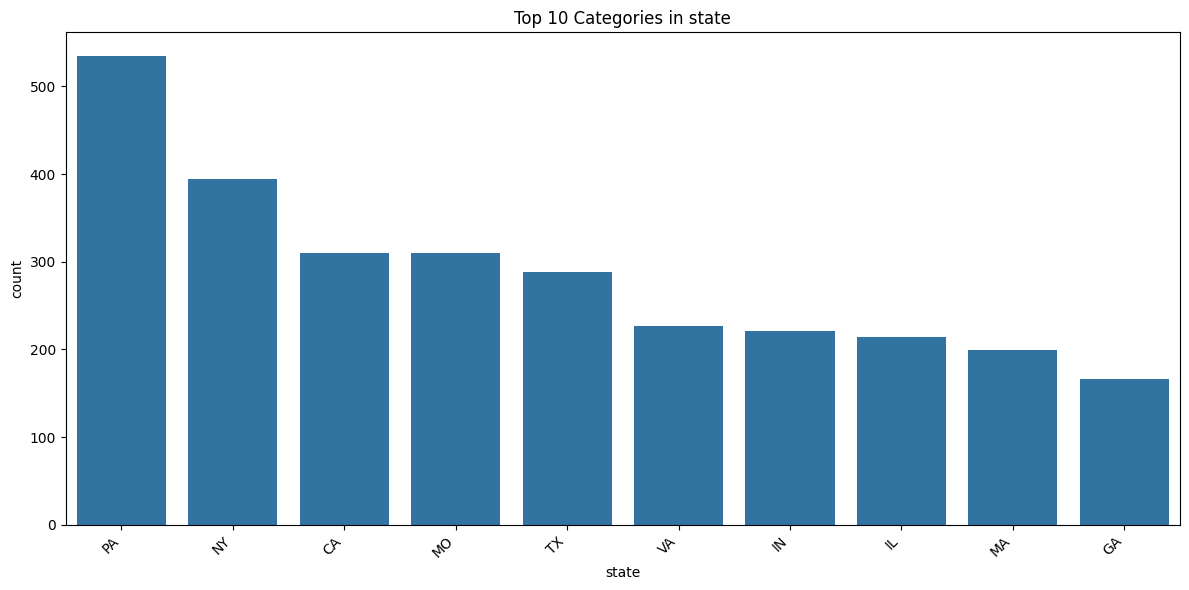

In [ ]:

# Categorical Variables
categorical_cols = ["institution_type", "state"]

# Bar plots for categorical variables
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    cat_counts = df.groupBy(col).count().orderBy(desc("count")).limit(10).toPandas()
    sns.barplot(x=col, y="count", data=cat_counts)
    plt.title(f'Top 10 Categories in {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # plt.savefig(f'{col}_distribution.png')
    plt.show()
    plt.close()



> The numerical variables (total accounts, issuer payments, new accounts) all show highly skewed distributions, indicating a small number of very large or high-value agreements alongside many smaller ones.

> Alumni associations and universities dominate the types of institutions involved in these agreements, suggesting a focus on targeting current students and graduates.

> There's significant geographic variation in where these agreements are concentrated, with some states having many more than others. This could reflect differences in state regulations, the number of higher education institutions, or the aggressiveness of card issuers in different regions.

## Bivariate Analysis

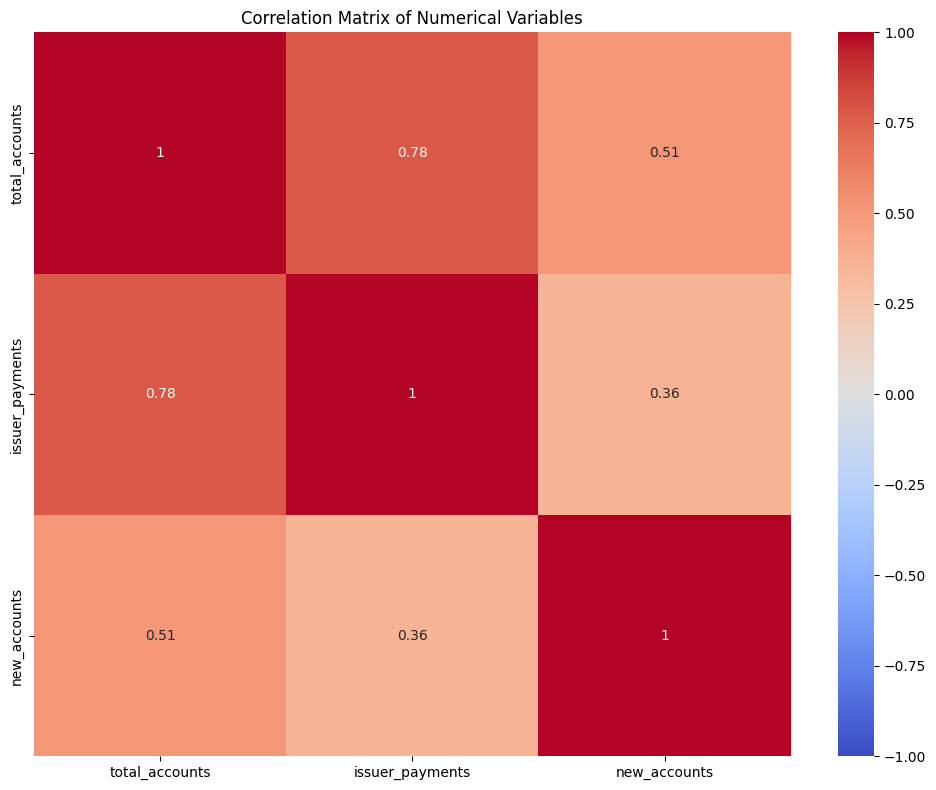

In [ ]:
# Bivariate Analysis

# Correlation matrix for numerical variables
corr_matrix = df.select(numerical_cols).toPandas().corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
# plt.savefig('correlation_matrix.png')
plt.show()
plt.close()


> Total Accounts and Issuer Payments: Strong positive correlation (0.78). This suggests that institutions with more total accounts tend to receive higher payments from issuers.

> Total Accounts and New Accounts: Moderate positive correlation (0.51). Institutions with more total accounts tend to open more new accounts, but the relationship is not as strong as with issuer payments.

> Issuer Payments and New Accounts: Weak to moderate positive correlation (0.36). There's a slight tendency for institutions receiving higher payments to open more new accounts, but the relationship is not very strong.

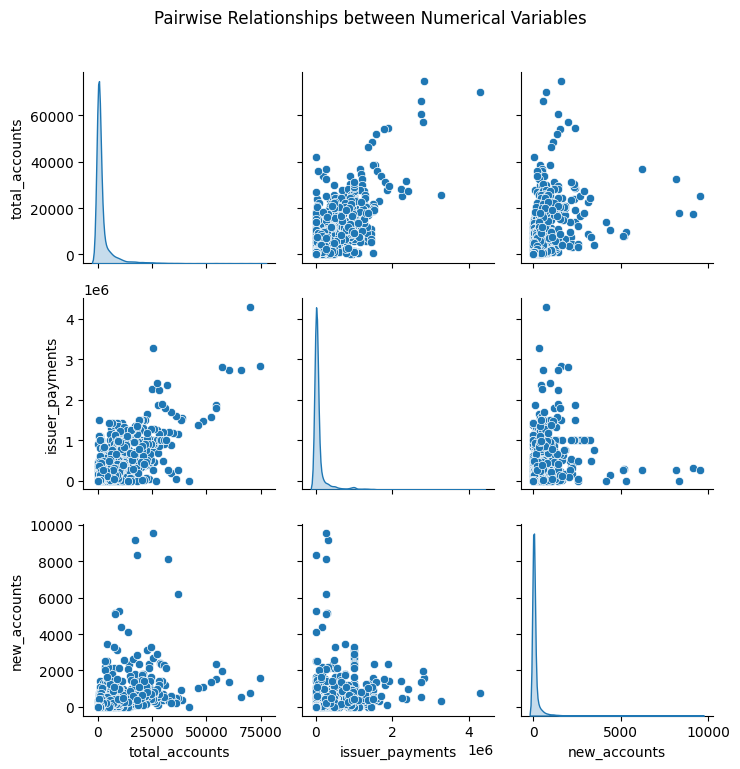

In [ ]:
# Scatter plots for numerical variables
sns.pairplot(df.select(numerical_cols).toPandas(), diag_kind='kde')
plt.suptitle('Pairwise Relationships between Numerical Variables', y=1.02)
plt.tight_layout()
# plt.savefig('numerical_pairplot.png')
plt.show()
plt.close()





> Total Accounts vs. Issuer Payments: The scatter plot shows a clear positive relationship, confirming the strong correlation. However, the relationship appears non-linear, with some outliers at high values for both variables.

> Total Accounts vs. New Accounts: There's a positive relationship, but with high variability. Some institutions with high total accounts have relatively few new accounts, while others have many.

>Issuer Payments vs. New Accounts: The relationship is less clear, with high variability. This aligns with the weaker correlation observed.

# 3. Market Share Analysis

In [ ]:
from pyspark.sql.functions import col, desc, count, mean, corr # Re-import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

market_share = df.groupBy("issuer") \
    .agg(sum("total_accounts").alias("TOTAL_ACCOUNTS_EOY"),
         sum("issuer_payments").alias("TOTAL_PAYMENTS"),
         sum("new_accounts").alias("TOTAL_NEW_ACCOUNTS"),
         count("institution").alias("NUM_INSTITUTIONS"))

total_accounts = market_share.agg(sum("TOTAL_ACCOUNTS_EOY")).collect()[0][0]
total_payments = market_share.agg(sum("TOTAL_PAYMENTS")).collect()[0][0]
total_new_accounts = market_share.agg(sum("TOTAL_NEW_ACCOUNTS")).collect()[0][0]
total_institutions = market_share.agg(sum("NUM_INSTITUTIONS")).collect()[0][0]

market_share = market_share.withColumn("ACCOUNT_SHARE", col("TOTAL_ACCOUNTS_EOY") / total_accounts) \
    .withColumn("PAYMENT_SHARE", col("TOTAL_PAYMENTS") / total_payments) \
    .withColumn("NEW_ACCOUNT_SHARE", col("TOTAL_NEW_ACCOUNTS") / total_new_accounts) \
    .withColumn("INSTITUTION_SHARE", col("NUM_INSTITUTIONS") / total_institutions)


print("Market Share Analysis:")
market_share.orderBy(desc("ACCOUNT_SHARE")).show()

Market Share Analysis:
+--------------------+------------------+--------------------+------------------+----------------+--------------------+--------------------+--------------------+--------------------+
|              issuer|TOTAL_ACCOUNTS_EOY|      TOTAL_PAYMENTS|TOTAL_NEW_ACCOUNTS|NUM_INSTITUTIONS|       ACCOUNT_SHARE|       PAYMENT_SHARE|   NEW_ACCOUNT_SHARE|   INSTITUTION_SHARE|
+--------------------+------------------+--------------------+------------------+----------------+--------------------+--------------------+--------------------+--------------------+
|FIA Card Services...|           7358811| 2.762011917599999E8|            216397|            3248|  0.6174886956556763|  0.5851040556576371| 0.37021950009409593|  0.5875542691751086|
|     Bank of America|           2028157| 5.893357693000001E7|             92237|             300| 0.17018564826776084| 0.12484477223442658|  0.1578022617234949| 0.05426917510853835|
|          Chase Bank|            575485|4.0131777019999996E7|

In [ ]:
from pyspark.sql.functions import format_number, round, col

# Round the share columns to 2 decimal places and TOTAL_PAYMENTS to millions
rounded_market_share = market_share.select(
    "issuer",
    "TOTAL_ACCOUNTS_EOY",
    round(col("TOTAL_PAYMENTS").cast("double") / 1000000, 0).alias("TOTAL_PAYMENTS_MILLIONS"),
    "TOTAL_NEW_ACCOUNTS",
    "NUM_INSTITUTIONS",
    format_number("ACCOUNT_SHARE", 2).alias("ACCOUNT_SHARE"),
    format_number("PAYMENT_SHARE", 2).alias("PAYMENT_SHARE"),
    format_number("NEW_ACCOUNT_SHARE", 2).alias("NEW_ACCOUNT_SHARE"),
    format_number("INSTITUTION_SHARE", 2).alias("INSTITUTION_SHARE")
)

print("Market Share Analysis:")
rounded_market_share.orderBy(desc("ACCOUNT_SHARE")).show(truncate=False)

# # Save the figure
# save_figure(fig, 'rounded_market_share')
# plt.close(fig)

Market Share Analysis:
+---------------------------------------------+------------------+-----------------------+------------------+----------------+-------------+-------------+-----------------+-----------------+
|issuer                                       |TOTAL_ACCOUNTS_EOY|TOTAL_PAYMENTS_MILLIONS|TOTAL_NEW_ACCOUNTS|NUM_INSTITUTIONS|ACCOUNT_SHARE|PAYMENT_SHARE|NEW_ACCOUNT_SHARE|INSTITUTION_SHARE|
+---------------------------------------------+------------------+-----------------------+------------------+----------------+-------------+-------------+-----------------+-----------------+
|FIA Card Services, N.A.                      |7358811           |276.0                  |216397            |3248            |0.62         |0.59         |0.37             |0.59             |
|Bank of America                              |2028157           |59.0                   |92237             |300             |0.17         |0.12         |0.16             |0.05             |
|Chase Bank           

Market Share Analysis figure has been saved as PNG and PDF files.

Market Share Analysis Data:
+---------------------------------------------+------------------+-----------------------+------------------+----------------+-------------+-------------+-----------------+-----------------+
|issuer                                       |TOTAL_ACCOUNTS_EOY|TOTAL_PAYMENTS_MILLIONS|TOTAL_NEW_ACCOUNTS|NUM_INSTITUTIONS|ACCOUNT_SHARE|PAYMENT_SHARE|NEW_ACCOUNT_SHARE|INSTITUTION_SHARE|
+---------------------------------------------+------------------+-----------------------+------------------+----------------+-------------+-------------+-----------------+-----------------+
|FIA Card Services, N.A.                      |7358811           |276.0                  |216397            |3248            |0.62         |0.59         |0.37             |0.59             |
|Bank of America                              |2028157           |59.0                   |92237             |300             |0.17         |0

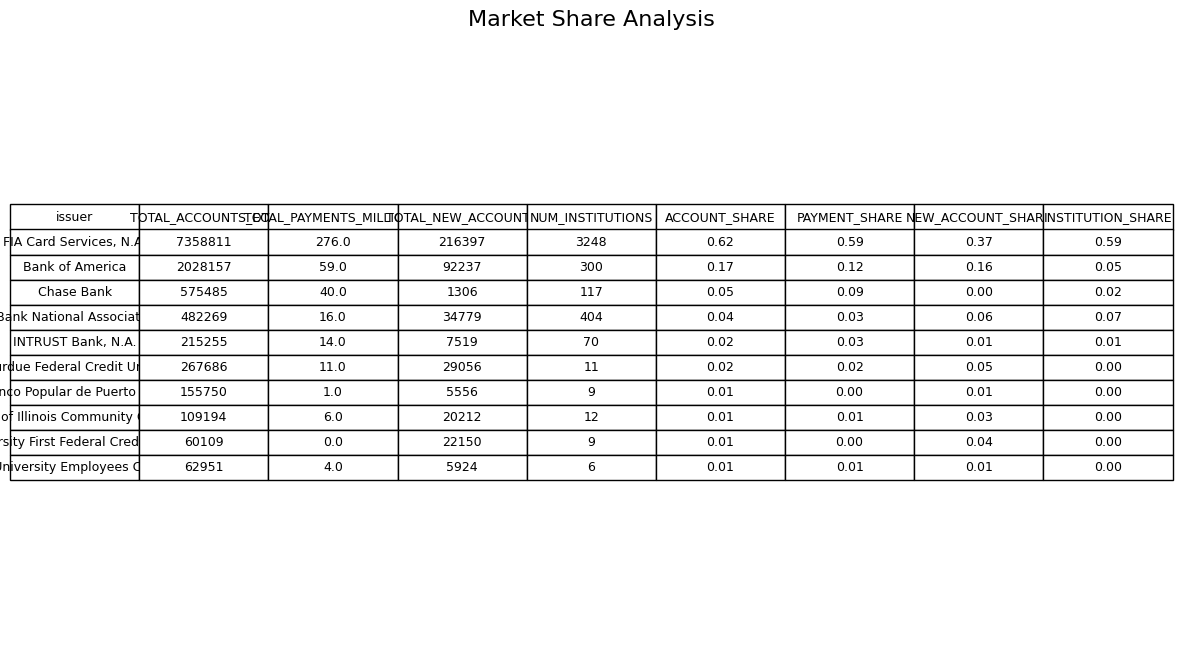

In [ ]:
from pyspark.sql.functions import format_number, round, col
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Round the share columns to 2 decimal places and TOTAL_PAYMENTS to millions
rounded_market_share = market_share.select(
    "issuer",
    "TOTAL_ACCOUNTS_EOY",
    round(col("TOTAL_PAYMENTS").cast("double") / 1000000, 0).alias("TOTAL_PAYMENTS_MILLIONS"),
    "TOTAL_NEW_ACCOUNTS",
    "NUM_INSTITUTIONS",
    format_number("ACCOUNT_SHARE", 2).alias("ACCOUNT_SHARE"),
    format_number("PAYMENT_SHARE", 2).alias("PAYMENT_SHARE"),
    format_number("NEW_ACCOUNT_SHARE", 2).alias("NEW_ACCOUNT_SHARE"),
    format_number("INSTITUTION_SHARE", 2).alias("INSTITUTION_SHARE")
)

# Convert to Pandas DataFrame for easier plotting
pd_df = rounded_market_share.orderBy(desc("ACCOUNT_SHARE")).limit(10).toPandas()

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=pd_df.values, colLabels=pd_df.columns, cellLoc='center', loc='center')

# Set font size
table.auto_set_font_size(False)
table.set_fontsize(9)

# Scale the table to fit the figure
table.scale(1, 1.5)

# Set title
plt.title("Market Share Analysis", fontsize=16)

# Function to save figure
def save_figure(fig, filename):
    # Save as PNG
    fig.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')
    # Save as PDF
    with PdfPages(f'{filename}.pdf') as pdf:
        pdf.savefig(fig, bbox_inches='tight')

# # Save the figure
# save_figure(fig, 'rounded_market_share')
# plt.close(fig)

print("Market Share Analysis figure has been saved as PNG and PDF files.")

# Also print the data for reference
print("\nMarket Share Analysis Data:")
rounded_market_share.orderBy(desc("ACCOUNT_SHARE")).show(truncate=False)

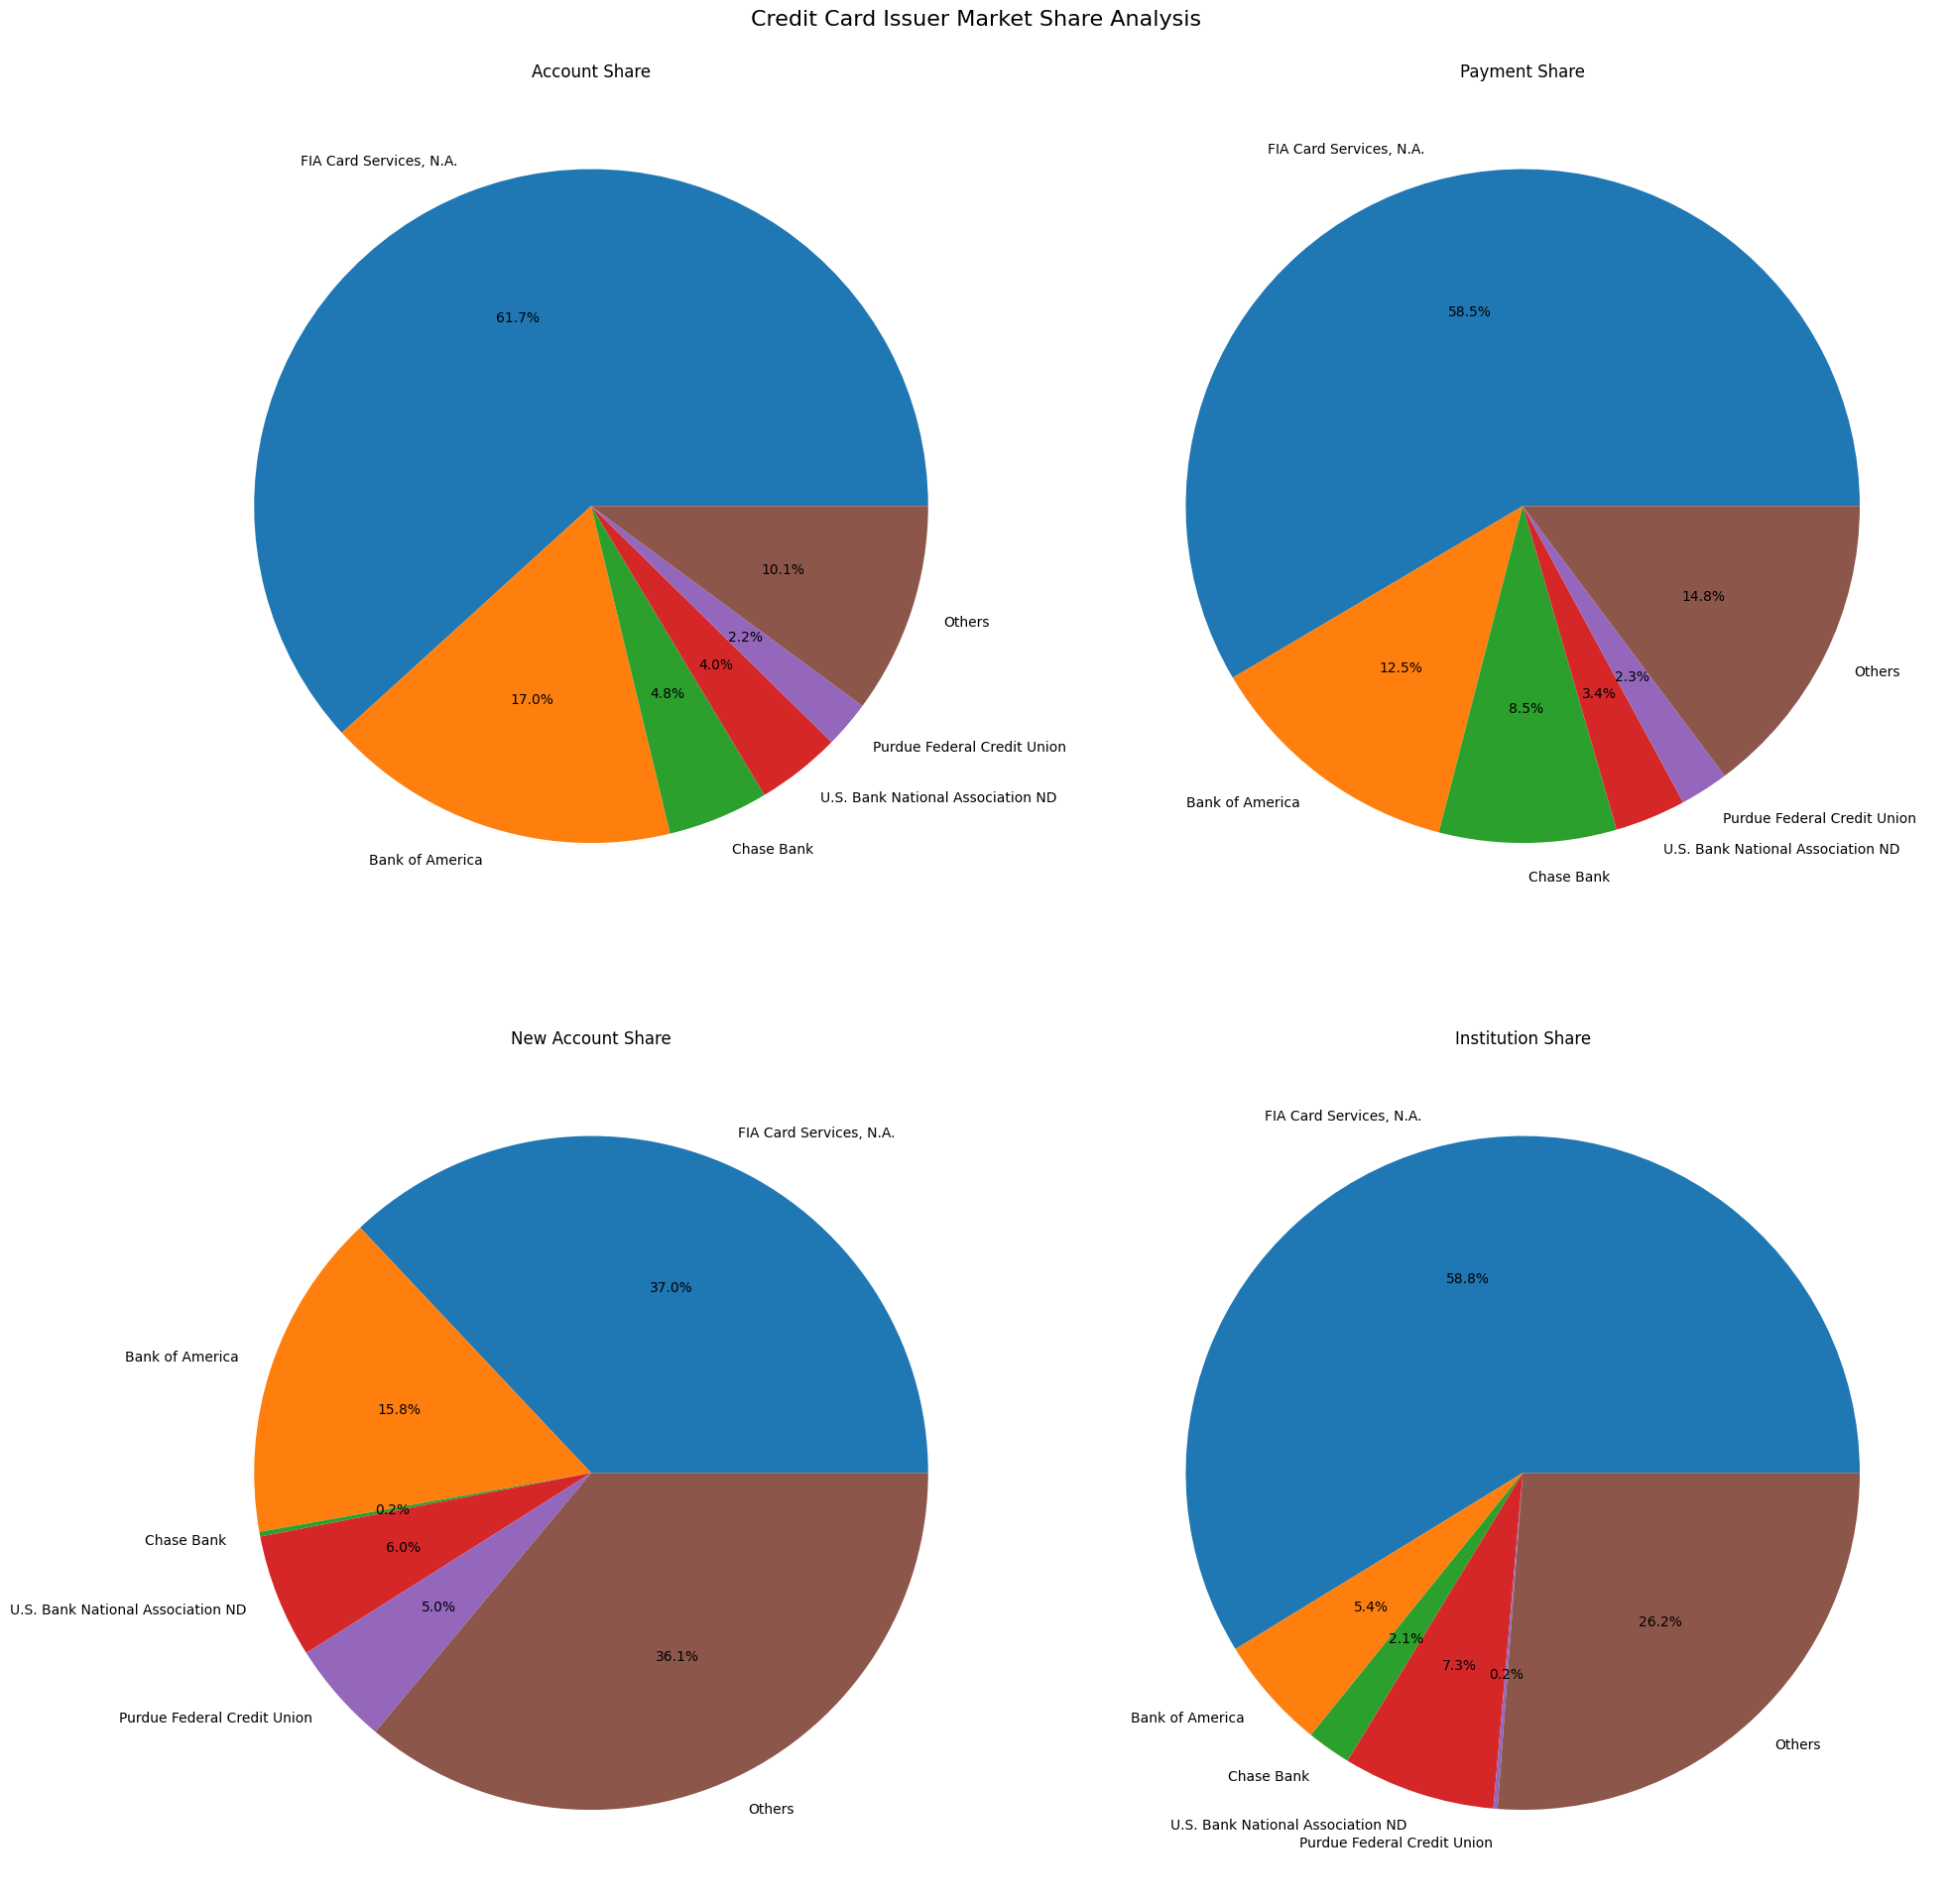

Market share pie charts have been saved as PNG and PDF files.
                              issuer  ACCOUNT_SHARE  PAYMENT_SHARE  \
0            FIA Card Services, N.A.       0.617489       0.585104   
1                    Bank of America       0.170186       0.124845   
2                         Chase Bank       0.048290       0.085015   
3  U.S. Bank National Association ND       0.040468       0.033991   
4        Purdue Federal Credit Union       0.022462       0.023302   

   NEW_ACCOUNT_SHARE  INSTITUTION_SHARE  
0           0.370220           0.587554  
1           0.157802           0.054269  
2           0.002234           0.021165  
3           0.059501           0.073082  
4           0.049710           0.001990  


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

# Assuming market_share is your Spark DataFrame
# Convert Spark DataFrame to Pandas DataFrame for easier plotting
market_share_pd = market_share.orderBy(desc("ACCOUNT_SHARE")).toPandas()

# Select top 8 issuers for better visibility
top_8_issuers = market_share_pd.head(5)

# Function to save figures
def save_figure(fig, filename):
    # Save as PNG
    fig.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')
    # Save as PDF
    with PdfPages(f'{filename}.pdf') as pdf:
        pdf.savefig(fig, bbox_inches='tight')

# Create pie charts for each share type
share_types = ['ACCOUNT_SHARE', 'PAYMENT_SHARE', 'NEW_ACCOUNT_SHARE', 'INSTITUTION_SHARE']
titles = ['Account Share', 'Payment Share', 'New Account Share', 'Institution Share']

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Credit Card Issuer Market Share Analysis', fontsize=16)

for i, (share_type, title) in enumerate(zip(share_types, titles)):
    row = i // 2
    col = i % 2

    # Calculate 'Others' share
    others_share = 1 - top_8_issuers[share_type].sum()

    # Create a new series with 'Others' included
    shares = pd.concat([top_8_issuers[share_type], pd.Series([others_share], index=['Others'])])
    labels = pd.concat([top_8_issuers['issuer'], pd.Series(['Others'])])

    axs[row, col].pie(shares, labels=labels, autopct='%1.1f%%')
    axs[row, col].set_title(title)

plt.tight_layout()
plt.show()

# # Save the figure
# save_figure(fig, 'market_share_analysis')
# plt.close(fig)

print("Market share pie charts have been saved as PNG and PDF files.")

# Print the detailed market share data for top 8 issuers
print(top_8_issuers[['issuer', 'ACCOUNT_SHARE', 'PAYMENT_SHARE', 'NEW_ACCOUNT_SHARE', 'INSTITUTION_SHARE']])

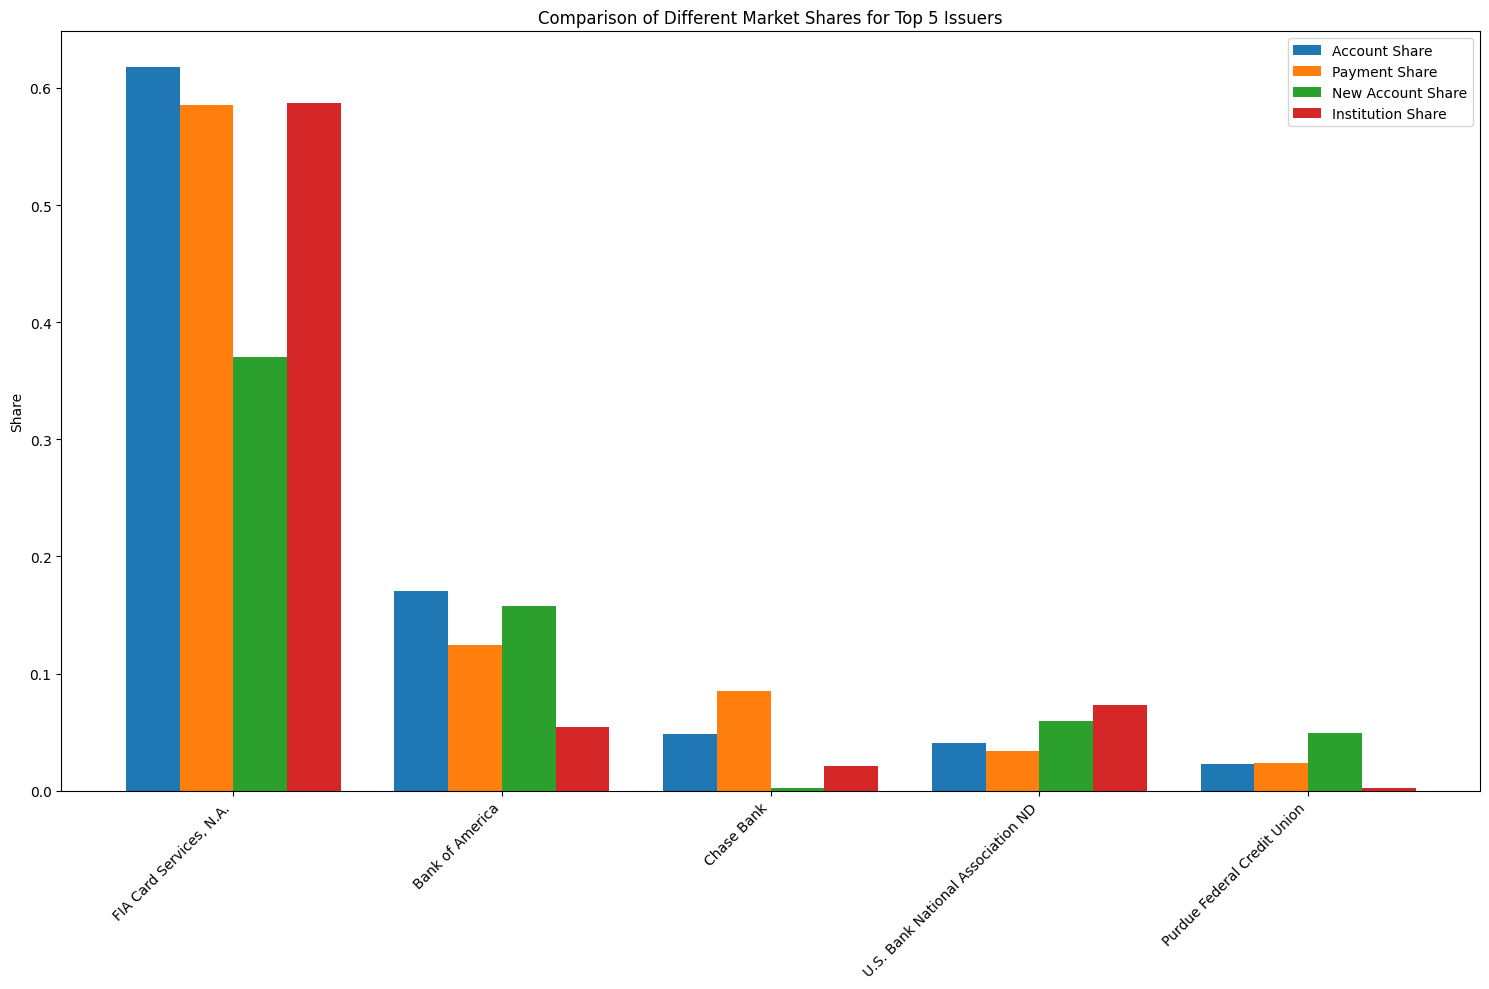

Figures have been saved as PNG and PDF files.
                               issuer  ACCOUNT_SHARE  PAYMENT_SHARE  \
42            FIA Card Services, N.A.       0.617489       0.585104   
21                    Bank of America       0.170186       0.124845   
28                         Chase Bank       0.048290       0.085015   
51  U.S. Bank National Association ND       0.040468       0.033991   
44        Purdue Federal Credit Union       0.022462       0.023302   
35                 INTRUST Bank, N.A.       0.018062       0.029792   
10       Banco Popular de Puerto Rico       0.013069       0.001275   
52     Boeing Employees' Credit Union       0.010204       0.003543   

    NEW_ACCOUNT_SHARE  INSTITUTION_SHARE  
42           0.370220           0.587554  
21           0.157802           0.054269  
28           0.002234           0.021165  
51           0.059501           0.073082  
44           0.049710           0.001990  
35           0.012864           0.012663  
10           

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# Convert Spark DataFrame to Pandas DataFrame for easier plotting
market_share_pd = market_share.toPandas()

# Sort the dataframe by Account Share
market_share_pd = market_share_pd.sort_values('ACCOUNT_SHARE', ascending=False)

# Select top 10 issuers for better visibility
top_10_issuers = market_share_pd.head(8)

# Function to save figures
def save_figure(fig, filename):
    # Save as PNG
    fig.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')
    # Save as PDF
    with PdfPages(f'{filename}.pdf') as pdf:
        pdf.savefig(fig, bbox_inches='tight')


# 2. Bar chart
top_5_issuers = market_share_pd.head(5)

fig, ax = plt.subplots(figsize=(15, 10))

x = range(len(top_5_issuers))
width = 0.2

ax.bar([i - 1.5*width for i in x], top_5_issuers['ACCOUNT_SHARE'], width, label='Account Share')
ax.bar([i - 0.5*width for i in x], top_5_issuers['PAYMENT_SHARE'], width, label='Payment Share')
ax.bar([i + 0.5*width for i in x], top_5_issuers['NEW_ACCOUNT_SHARE'], width, label='New Account Share')
ax.bar([i + 1.5*width for i in x], top_5_issuers['INSTITUTION_SHARE'], width, label='Institution Share')

ax.set_ylabel('Share')
ax.set_title('Comparison of Different Market Shares for Top 5 Issuers')
ax.set_xticks(x)
ax.set_xticklabels(top_5_issuers['issuer'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# # Save bar chart
# save_figure(fig, 'market_share_bar_chart')
# plt.close(fig)

print("Figures have been saved as PNG and PDF files.")

# Print the detailed market share data for top 10 issuers
print(top_10_issuers[['issuer', 'ACCOUNT_SHARE', 'PAYMENT_SHARE', 'NEW_ACCOUNT_SHARE', 'INSTITUTION_SHARE']])

> FIA Card Services, N.A. dominates the market across all metrics, holding over 60% of the account share and around 55-60% of other shares.

> Bank of America is a distant second, with about 15-20% market share across metrics.

> Chase Bank, U.S. Bank National Association ND, and Purdue Federal Credit Union have significantly smaller market shares.

> There are notable differences in how issuers perform across different metrics. For example, Chase Bank has a higher payment share relative to its account share, suggesting they may focus on higher-value agreements.

> Institution share doesn't always correlate with other metrics, indicating some issuers may have many smaller agreements while others focus on fewer, larger institutions.

# 4. Competitive Analysis

In [ ]:
top_issuers = market_share.orderBy(desc("ACCOUNT_SHARE")).limit(5)
print("Top 5 Credit Card Issuers:")
top_issuers.show()

print("\nMarket concentration (HHI):")
hhi = market_share.selectExpr("sum(power(ACCOUNT_SHARE, 2)) as hhi").collect()[0]['hhi']
print(f"HHI: {hhi:.4f}")

Top 5 Credit Card Issuers:
+--------------------+------------------+--------------------+------------------+----------------+--------------------+--------------------+--------------------+--------------------+
|              issuer|TOTAL_ACCOUNTS_EOY|      TOTAL_PAYMENTS|TOTAL_NEW_ACCOUNTS|NUM_INSTITUTIONS|       ACCOUNT_SHARE|       PAYMENT_SHARE|   NEW_ACCOUNT_SHARE|   INSTITUTION_SHARE|
+--------------------+------------------+--------------------+------------------+----------------+--------------------+--------------------+--------------------+--------------------+
|FIA Card Services...|           7358811| 2.762011917599999E8|            216397|            3248|  0.6174886956556763|  0.5851040556576371| 0.37021950009409593|  0.5875542691751086|
|     Bank of America|           2028157| 5.893357693000001E7|             92237|             300| 0.17018564826776084| 0.12484477223442658|  0.1578022617234949| 0.05426917510853835|
|          Chase Bank|            575485|4.013177701999999

> Market Dominance: FIA Card Services is the clear market leader, holding about 61.75% of total accounts, 58.51% of payments, 37.02% of new accounts, and partnerships with 58.76% of institutions.

> Concentration: The Herfindahl-Hirschman Index (HHI) of 0.4156 indicates a highly concentrated market. An HHI above 0.25 is considered highly concentrated by regulatory standards.

Competitive Landscape:

>> Bank of America is a distant second, with significant shares across all metrics.

>> Chase Bank has a disproportionately high payment share compared to its account share, suggesting a focus on high-value partnerships.

>> U.S. Bank National Association has a balanced presence across metrics.
Purdue Federal Credit Union shows strength in new accounts but has very few institutional partnerships

##Herfindahl-Hirschman Index (HHI)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import plotly.graph_objects as go

# Convert Spark DataFrame to Pandas for easier plotting
top_issuers_pd = top_issuers.toPandas()


# 4. HHI Gauge Chart
fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = hhi,
    title = {'text': "Market Concentration (HHI)"},
    domain = {'x': [0, 1], 'y': [0, 1]},
    gauge = {
        'axis': {'range': [0, 1]},
        'steps': [
            {'range': [0, 0.15], 'color': "lightgray"},
            {'range': [0.15, 0.25], 'color': "gray"},
            {'range': [0.25, 1], 'color': "darkgray"}],
        'threshold': {
            'line': {'color': "red", 'width': 4},
            'thickness': 0.75,
            'value': hhi}}))

fig.write_image("hhi_gauge.png")
fig.show()


With an HHI of 0.4156, our market shows significant concentration, suggesting dominant players hold substantial market power. This high concentration may indicate limited competition, potential barriers to entry for new competitors, and possible regulatory scrutiny. Strategies should be developed to either maintain market position if a dominant player, or to find niche opportunities if a smaller competitor.

##Concentration Ratios, specifically CR3 and CR5

Concentration Ratio (CR3): 0.8360
Concentration Ratio (CR5): 0.8989


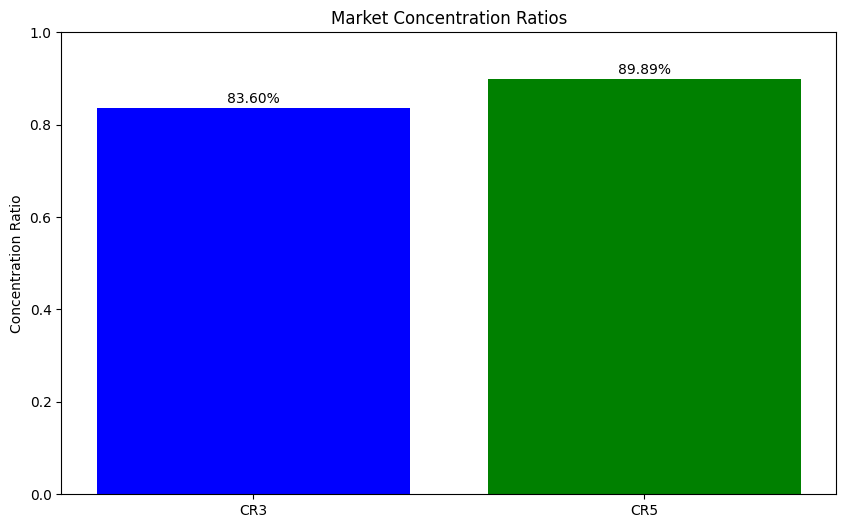

Concentration ratios chart saved as 'concentration_ratios.png'


In [ ]:
from pyspark.sql.functions import desc, sum as spark_sum

# Sort the market share data by ACCOUNT_SHARE in descending order
sorted_market_share = market_share.orderBy(desc("ACCOUNT_SHARE"))

# Calculate CR3 (Concentration Ratio for top 3 issuers)
cr3 = sorted_market_share.limit(3).agg(spark_sum("ACCOUNT_SHARE")).collect()[0][0]

# Calculate CR5 (Concentration Ratio for top 5 issuers)
cr5 = sorted_market_share.limit(5).agg(spark_sum("ACCOUNT_SHARE")).collect()[0][0]

# Print the results
print(f"Concentration Ratio (CR3): {cr3:.4f}")
print(f"Concentration Ratio (CR5): {cr5:.4f}")

# Optional: Create a bar chart to visualize CR3 and CR5
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(['CR3', 'CR5'], [cr3, cr5], color=['blue', 'green'])
plt.title('Market Concentration Ratios')
plt.ylabel('Concentration Ratio')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1

for i, v in enumerate([cr3, cr5]):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center')

# plt.savefig('concentration_ratios.png')
plt.show()
# plt.close()

print("Concentration ratios chart saved as 'concentration_ratios.png'")

> The CR3 of 0.8360 indicates that the top 3 issuers control 83.60% of the market, which is extremely high.

> The CR5 of 0.8989 shows that the top 5 issuers hold 89.89% of the market share, leaving only about 10% for all other competitors combined.

> This aligns with our high HHI of 0.4156, confirming a highly concentrated market.

> The market is dominated by a few major players, strongly suggesting oligopolistic tendencies.

> The relatively small difference between CR3 (83.60%) and CR5 (89.89%) indicates that the 4th and 5th largest issuers have a much smaller market share compared to the top 3.

# 5. Segmentation

In [ ]:
import pyspark.sql.functions as F

df = df.withColumn("INSTITUTION_TYPE",
    F.when(F.col("institution_type").contains("University"), "University")
    .when(F.col("institution_type").contains("Alumni"), "Alumni Association")
    .when(F.col("institution_type").contains("Foundation"), "Foundation")
    .otherwise("Other"))

segment_analysis = df.groupBy("INSTITUTION_TYPE", "issuer", "state") \
    .agg(F.sum("total_accounts").alias("TOTAL_ACCOUNTS"),
         F.sum("issuer_payments").alias("TOTAL_PAYMENTS"),
         F.sum("new_accounts").alias("TOTAL_NEW_ACCOUNTS"))

print("Enhanced Segmentation Analysis:")
segment_analysis.orderBy(F.desc("TOTAL_ACCOUNTS")).show(10)

Enhanced Segmentation Analysis:
+------------------+--------------------+-----+--------------+--------------------+------------------+
|  INSTITUTION_TYPE|              issuer|state|TOTAL_ACCOUNTS|      TOTAL_PAYMENTS|TOTAL_NEW_ACCOUNTS|
+------------------+--------------------+-----+--------------+--------------------+------------------+
|Alumni Association|FIA Card Services...|   TX|        520756|1.7989342320000008E7|             12552|
|Alumni Association|FIA Card Services...|   PA|        497538|2.0218827170000006E7|             11074|
|Alumni Association|FIA Card Services...|   CA|        460597|1.9370675159999996E7|             20411|
|Alumni Association|Purdue Federal Cr...|   IN|        267686|               1.1E7|             29056|
|        University|FIA Card Services...|   NY|        262210|   7610310.850000001|              5481|
|        University|FIA Card Services...|   CA|        254386|1.3755137880000005E7|             11406|
|             Other|FIA Card Services...|

##Institution Type Segmentation

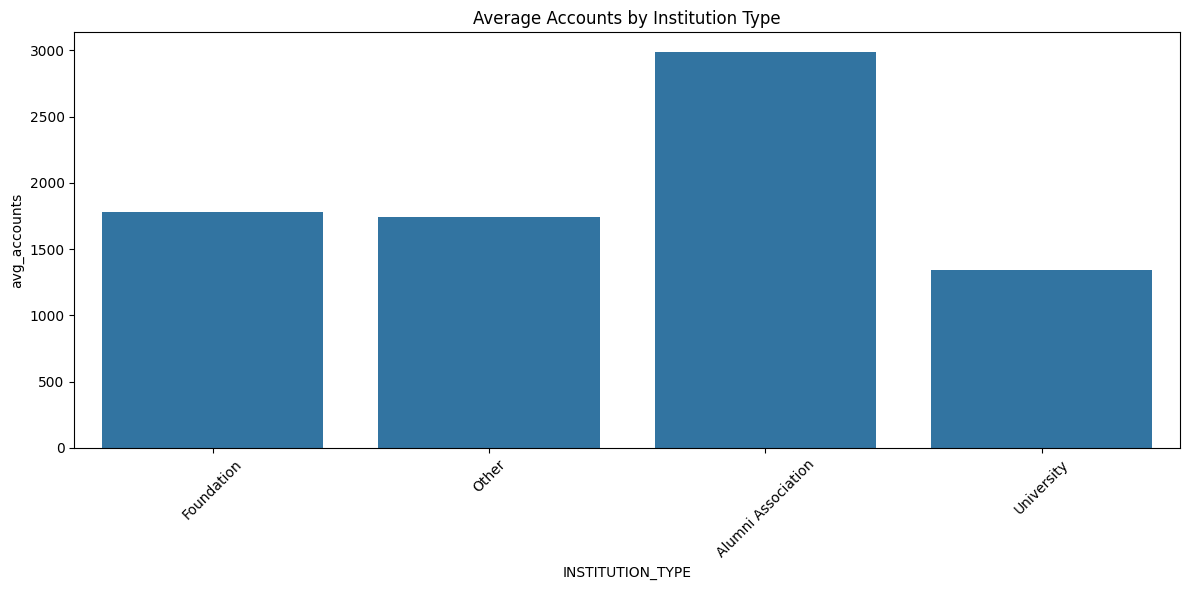

     INSTITUTION_TYPE  avg_accounts   avg_payments  count
0          Foundation   1776.287129   62994.445322    404
1               Other   1738.866667   38156.882346    810
2  Alumni Association   2986.985626  125766.858419   2435
3          University   1340.026078   58252.098300   1879


In [ ]:
from pyspark.sql.functions import avg, count
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your main DataFrame
institution_type_analysis = df.groupBy("INSTITUTION_TYPE").agg(
    avg("total_accounts").alias("avg_accounts"),
    avg("issuer_payments").alias("avg_payments"),
    count("*").alias("count")
)

# Convert to Pandas for visualization
inst_type_pd = institution_type_analysis.toPandas()

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='INSTITUTION_TYPE', y='avg_accounts', data=inst_type_pd)
plt.title('Average Accounts by Institution Type')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('institution_type_segmentation.png')
plt.show()
plt.close()


print(inst_type_pd)

> Alumni Associations lead: They have the highest average number of accounts, around 3000 per institution. This suggests alumni associations are particularly attractive partners for credit card issuers, likely due to their large, established networks of graduates.

> Foundations and "Other" categories: These have similar average account numbers, both around 1750 accounts. This indicates they are valuable partners but not as lucrative as alumni associations.

##Geographic Segmentation



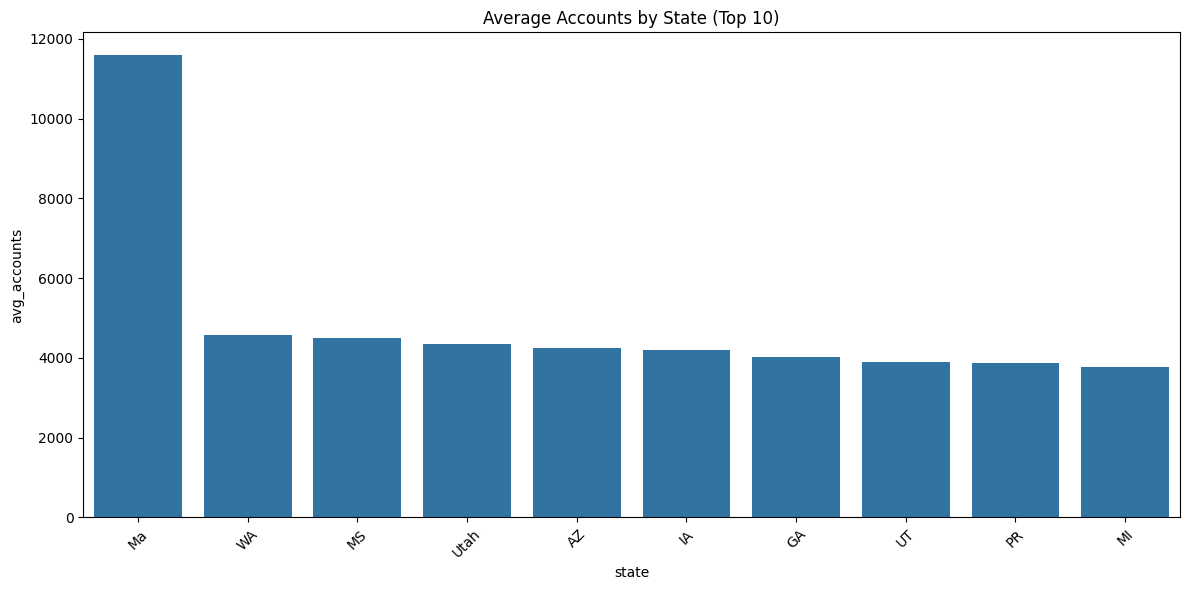

    state  avg_accounts   avg_payments  count
0    Utah   4346.000000       0.000000      1
1      SC   1800.406977   75638.734186     86
2      AZ   4252.243243  262897.978649     37
3      LA   1716.645833   39278.009479     96
4      MN    802.915254   88709.606780     59
5      NJ   1510.349057   43595.233585    106
6      DC   2860.121495   85226.265794    107
7      OR   1896.673913   94064.460870     46
8   Texas    166.000000    1103.595000      4
9      VA   1113.348018   29980.719559    227
10     RI   2173.142857   80529.112857     49
11     KY   1013.415385   15057.156462     65
12     WY    881.058824   28369.455294     17
13     NH   1789.285714   44031.699143     35
14     Al    128.666667       0.000000      3
15     MI   3780.279279  211313.777117    111
16     NV   1648.571429   40000.000000      7
17     WI   1764.685950   72956.557686    121
18     ID    883.785714   27064.598571     14
19     CA   3333.022581  155629.023903    310
20     NE    940.000000   19178.03

In [ ]:
geographic_analysis = df.groupBy("state").agg(
    avg("total_accounts").alias("avg_accounts"),
    avg("issuer_payments").alias("avg_payments"),
    count("*").alias("count")
)

# Convert to Pandas for visualization
geo_pd = geographic_analysis.toPandas()

# Visualization (top 10 states by average accounts)
plt.figure(figsize=(12, 6))
top_10_states = geo_pd.sort_values('avg_accounts', ascending=False).head(10)
sns.barplot(x='state', y='avg_accounts', data=top_10_states)
plt.title('Average Accounts by State (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('geographic_segmentation.png')
plt.show()
plt.close()


print(geo_pd)

> Massachusetts (MA) dominance: MA stands out significantly with an average of nearly 12,000 accounts per institution, more than double the next highest state. This suggests Massachusetts has particularly strong educational credit card partnerships, possibly due to its high concentration of colleges and universities.

> Cluster of followers: The next nine states (WA, MS, Utah, AZ, IA, GA, UT, PR, MI) all have similar average account numbers, ranging from about 3,800 to 4,600 accounts per institution.

##Institution Size Segmentation



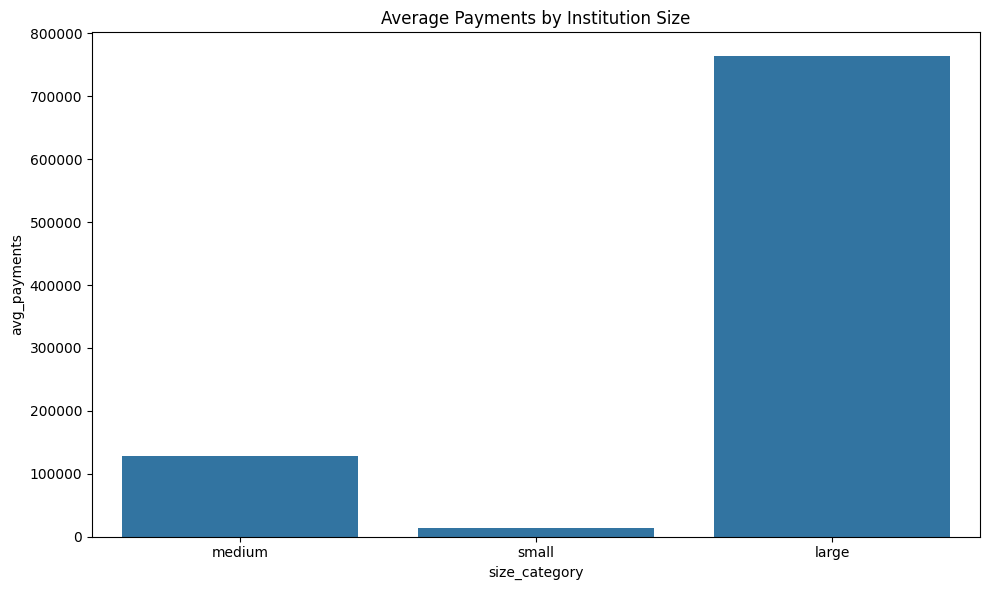

  size_category   avg_payments  count
0        medium  127407.008188   1582
1         small   14028.018703   3659
2         large  763653.018038    287


In [ ]:
from pyspark.sql.functions import when

df = df.withColumn("size_category",
    when(df.total_accounts < 1000, "small")
    .when((df.total_accounts >= 1000) & (df.total_accounts <= 10000), "medium")
    .otherwise("large")
)

size_analysis = df.groupBy("size_category").agg(
    avg("issuer_payments").alias("avg_payments"),
    count("*").alias("count")
)

# Convert to Pandas for visualization
size_pd = size_analysis.toPandas()

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='size_category', y='avg_payments', data=size_pd)
plt.title('Average Payments by Institution Size')
plt.tight_layout()
# plt.savefig('institution_size_segmentation.png')
plt.show()
plt.close()

print(size_pd)

> Size-Payment Correlation: There's a clear positive correlation between institution size and average payments received from credit card issuers.

> Large Institutions Dominance: Large institutions receive significantly higher average payments, approximately $775,000, which is dramatically more than medium and small institutions.

##Payment Level Segmentation



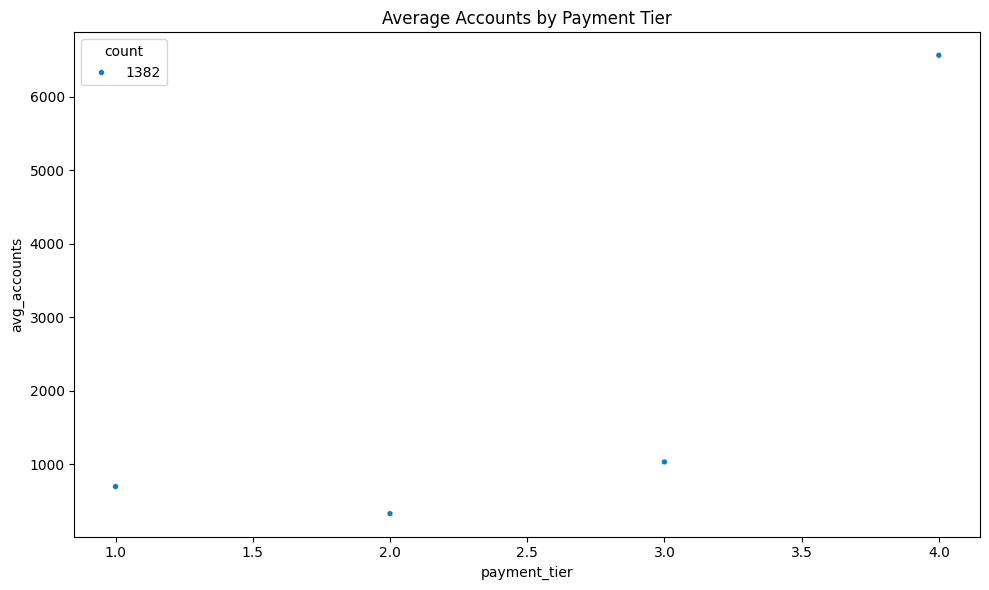

   payment_tier  avg_accounts   avg_payments  count
0             1    697.322721      37.702757   1382
1             2    328.871201    2549.452149   1382
2             3   1032.226483   16199.628456   1382
3             4   6564.821997  322786.895049   1382


In [ ]:
from pyspark.sql.functions import ntile
from pyspark.sql import Window

# Create a WindowSpec
w = Window.orderBy(df.issuer_payments.asc())

df = df.withColumn("payment_tier", ntile(4).over(w))

payment_analysis = df.groupBy("payment_tier").agg(
    avg("total_accounts").alias("avg_accounts"),
    avg("issuer_payments").alias("avg_payments"),
    count("*").alias("count")
)

# Convert to Pandas for visualization
payment_pd = payment_analysis.toPandas()

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='payment_tier', y='avg_accounts', size='count', data=payment_pd)
plt.title('Average Accounts by Payment Tier')
plt.tight_layout()
# plt.savefig('payment_level_segmentation.png')
plt.show()
plt.close()

print(payment_pd)

##Growth Rate Segmentation

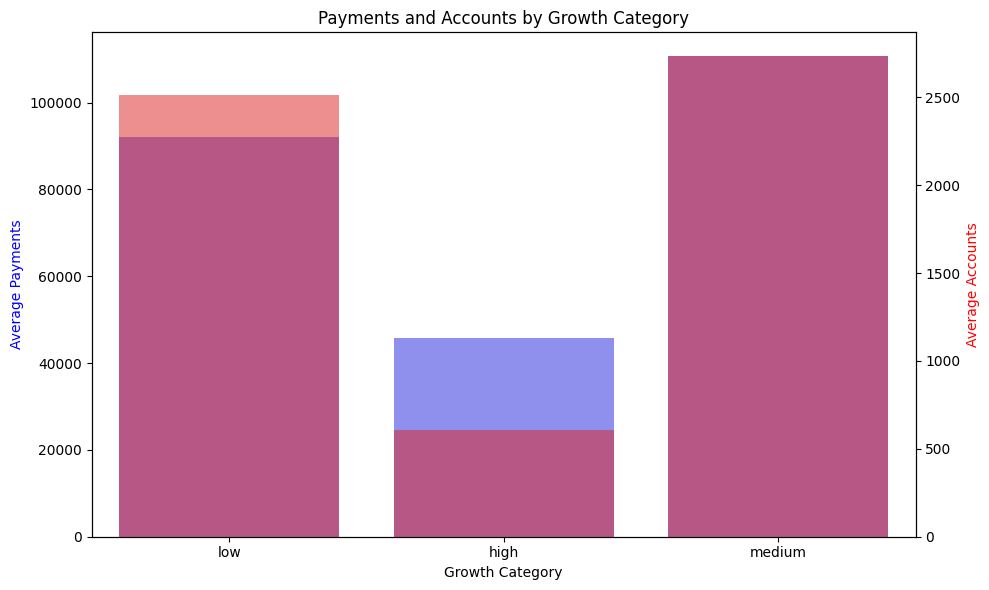

  growth_category   avg_payments  avg_accounts  count
0             low   92101.942244   2514.979741   3554
1            high   45759.868310    606.388204   1136
2          medium  110669.821511   2732.966587    838


In [ ]:
from pyspark.sql.functions import col

df = df.withColumn("growth_rate", col("new_accounts") / col("total_accounts"))
df = df.withColumn("growth_category",
    when(df.growth_rate < 0.05, "low")
    .when((df.growth_rate >= 0.05) & (df.growth_rate < 0.15), "medium")
    .otherwise("high")
)

growth_analysis = df.groupBy("growth_category").agg(
    avg("issuer_payments").alias("avg_payments"),
    avg("total_accounts").alias("avg_accounts"),
    count("*").alias("count")
)

# Convert to Pandas for visualization
growth_pd = growth_analysis.toPandas()

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

sns.barplot(x='growth_category', y='avg_payments', data=growth_pd, ax=ax1, color='b', alpha=0.5)
sns.barplot(x='growth_category', y='avg_accounts', data=growth_pd, ax=ax2, color='r', alpha=0.5)

ax1.set_xlabel('Growth Category')
ax1.set_ylabel('Average Payments', color='b')
ax2.set_ylabel('Average Accounts', color='r')

plt.title('Payments and Accounts by Growth Category')
plt.tight_layout()
# plt.savefig('growth_rate_segmentation.png')
plt.show()
plt.close()

print(growth_pd)

# 6. Regression Analysis

In [ ]:
# Prepare data for machine learning
categorical_cols = ["INSTITUTION_TYPE", "city", "state", "status", "in_effect_next_year"] # Use the new column name
numeric_cols = ["total_accounts", "issuer_payments", "new_accounts"]

stages = []

for categoricalCol in categorical_cols:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Create and train the model
label_indexer = StringIndexer(inputCol="issuer", outputCol="label")
stages += [label_indexer]

lr = LogisticRegression(featuresCol="features", labelCol="label")
stages += [lr]

pipeline = Pipeline(stages=stages)
model = pipeline.fit(df)

# Make predictions
predictions = model.transform(df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Advanced Regression Analysis Results:")
print(f"Model Accuracy: {accuracy:.4f}")

Advanced Regression Analysis Results:
Model Accuracy: 0.9088


## Feature Importance

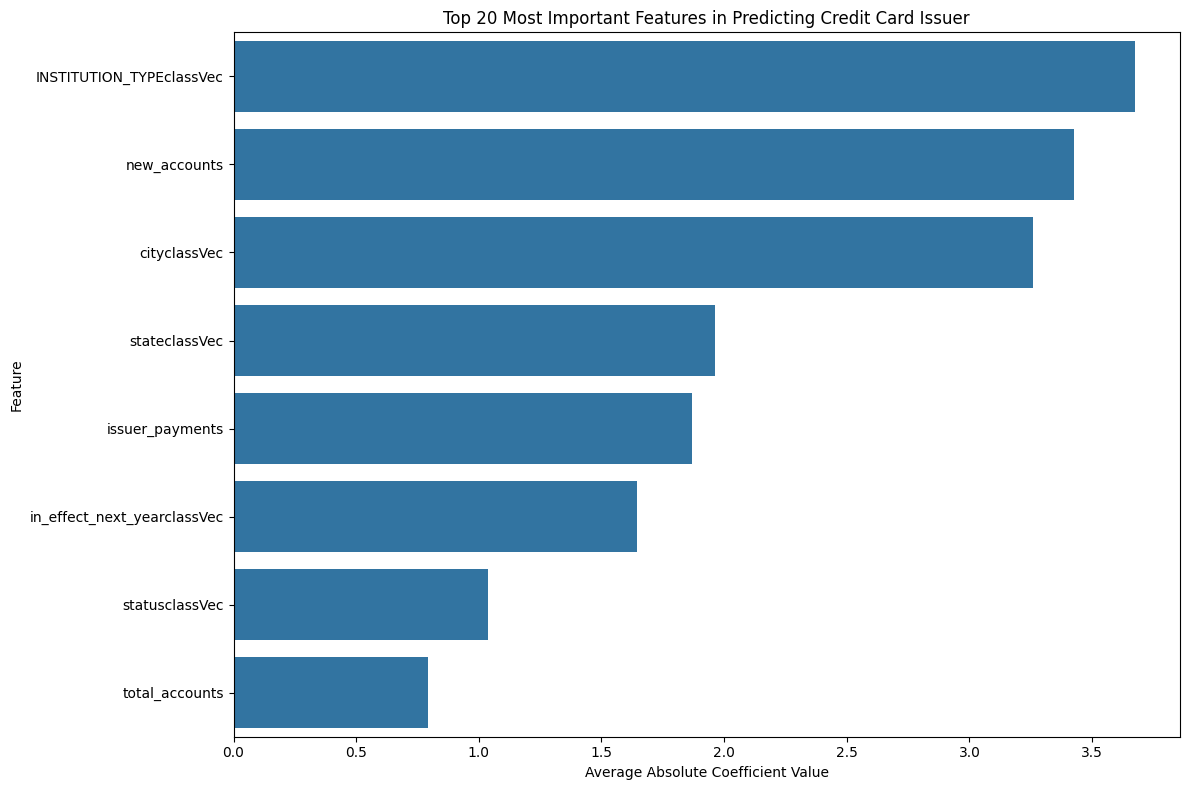

                       Feature  Importance
0     INSTITUTION_TYPEclassVec    3.674913
7                 new_accounts    3.426318
1                 cityclassVec    3.257965
2                stateclassVec    1.962988
6              issuer_payments    1.867953
4  in_effect_next_yearclassVec    1.646255
3               statusclassVec    1.037778
5               total_accounts    0.793063


In [ ]:
# Extract feature importances
lrModel = model.stages[-1]
feature_names = assembler.getInputCols()
num_classes = lrModel.numClasses

# Get the coefficient matrix
coef_matrix = lrModel.coefficientMatrix.toArray()

# Calculate the average absolute coefficient value for each feature across all classes
# Ensure feature_importance has the same length as feature_names
feature_importance = np.mean(np.abs(coef_matrix), axis=0)[:len(feature_names)]

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Most Important Features in Predicting Credit Card Issuer')
plt.xlabel('Average Absolute Coefficient Value')
plt.tight_layout()
plt.savefig('important_features.png')
plt.show()
plt.close()

# Print the top 20 features and their importance scores
print(feature_importance_df.head(20))

>Institution Type: The most important feature is the institution type (INSTITUTION_TYPEclassVec). This suggests that different credit card issuers have strong preferences or strategies for partnering with specific types of educational institutions (e.g., universities, community colleges, or technical schools).

>New Accounts: The second most important feature is the number of new accounts. This indicates that the growth rate of new card accounts is a crucial factor in determining which issuer is likely to partner with an institution.